In [1]:
# Install libraries
!pip install -r requirements.txt

# Predicting Kills and Headshots for CS

**Goal**: Predict the kills and headshots for a player's next game using historical HLTV data.

## Definitions

- **Rating**: A metric calculated by comparing a player's average stats:
  - Kills per round
  - Survived rounds per round
  - Number of rounds with multiple kills
  
- **KAST**: The percentage of rounds where a player contributes in one or more of the following ways:
  - Killing an enemy
  - Assisting a teammate
  - Surviving a round
  - Getting revenge on an enemy (trading for a teammate's death)

- **K-D Diff**: The difference between kills and deaths (Kills - Deaths).

- **ADR**: The average damage per round, measuring the damage output of a player.

- **FK Diff**: The difference in first kills (positive or negative) a player contributes, often reflecting early-round aggression.


In [2]:
import joblib
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings, json, joblib

import category_encoders as ce
from utils import project_player

# Machine learning
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor

# Metrics
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error

warnings.filterwarnings("ignore")

## Import Data

In [3]:
# Import player ranks (Ordered from best to worse)
top_players_2024 = json.load(open("./player_ranks/2024.json"))["2024"]
top_players_2023 = json.load(open("./player_ranks/2023.json"))["2023"]

In [4]:
# Import team ranks (Ordered from best to worse)
top_teams_2024 = json.load(open("./team_ranks/2024.json"))["2024"]
top_teams_2023 = json.load(open("./team_ranks/2023.json"))["2023"]

In [5]:
# Load dataframes for both years
df1 = pd.read_csv("./data/2024.csv", index_col=[0])
df2 = pd.read_csv("./data/2023.csv", index_col=[0])

# Concat the data to a single dataframe
cs_data = pd.concat([df1, df2], ignore_index=True)

cs_data.head()

,Event,Date,Map,Map Number,Team,Name,Kills,Headshots,Assists,Deaths,...,Teammate 4,Opponent 1,Opponent 2,Opponent 3,Opponent 4,Opponent 5,Teammate 5,Opponent 6,Opponent 7,Teammate 6
0,ESEA Advanced Season 50 North America,2024-09-21 21:30,Mirage,1,Akimbo,kralz,30,10,13,29,...,kmrn,chop,motm,stamina,CLASIA,BeaKie,NaN,NaN,NaN,NaN
1,ESEA Advanced Season 50 North America,2024-09-21 21:30,Mirage,1,Akimbo,N2o,35,9,7,32,...,kmrn,chop,motm,stamina,CLASIA,BeaKie,NaN,NaN,NaN,NaN
2,ESEA Advanced Season 50 North America,2024-09-21 21:30,Mirage,1,Akimbo,laxiee,27,15,14,32,...,kmrn,chop,motm,stamina,CLASIA,BeaKie,NaN,NaN,NaN,NaN
3,ESEA Advanced Season 50 North America,2024-09-21 21:30,Mirage,1,Akimbo,obi,25,12,12,30,...,kmrn,chop,motm,stamina,CLASIA,BeaKie,NaN,NaN,NaN,NaN
4,ESEA Advanced Season 50 North America,2024-09-21 21:30,Mirage,1,Akimbo,kmrn,24,14,6,29,...,obi,chop,motm,stamina,CLASIA,BeaKie,NaN,NaN,NaN,NaN


In [6]:
# Convert data to datetime
cs_data["Date"] = pd.to_datetime(cs_data["Date"])

In [7]:
# Unique teams and players
team_df = cs_data[["Date", "Name", "Team"]].drop_duplicates()
team_df.reset_index(drop=True, inplace=True)
team_df.head()

,Date,Name,Team
0,2024-09-21 21:30:00,kralz,Akimbo
1,2024-09-21 21:30:00,N2o,Akimbo
2,2024-09-21 21:30:00,laxiee,Akimbo
3,2024-09-21 21:30:00,obi,Akimbo
4,2024-09-21 21:30:00,kmrn,Akimbo


In [8]:
# Concat the data
cs_data = \
cs_data.merge(
    right=team_df.add_prefix("Opponent "),
    left_on=["Date", "Opponent 1"],
    right_on=["Opponent Date", "Opponent Name"],
    how="left",
).drop(columns=["Opponent Date", "Opponent Name"])

# Opponents
opponents = cs_data.pop("Opponent Team")

# Append back to the dataframe
cs_data.insert(5, "Opponent Team", opponents)

cs_data.head()

,Event,Date,Map,Map Number,Team,Opponent Team,Name,Kills,Headshots,Assists,...,Teammate 4,Opponent 1,Opponent 2,Opponent 3,Opponent 4,Opponent 5,Teammate 5,Opponent 6,Opponent 7,Teammate 6
0,ESEA Advanced Season 50 North America,2024-09-21 21:30:00,Mirage,1,Akimbo,undefined,kralz,30,10,13,...,kmrn,chop,motm,stamina,CLASIA,BeaKie,NaN,NaN,NaN,NaN
1,ESEA Advanced Season 50 North America,2024-09-21 21:30:00,Mirage,1,Akimbo,undefined,N2o,35,9,7,...,kmrn,chop,motm,stamina,CLASIA,BeaKie,NaN,NaN,NaN,NaN
2,ESEA Advanced Season 50 North America,2024-09-21 21:30:00,Mirage,1,Akimbo,undefined,laxiee,27,15,14,...,kmrn,chop,motm,stamina,CLASIA,BeaKie,NaN,NaN,NaN,NaN
3,ESEA Advanced Season 50 North America,2024-09-21 21:30:00,Mirage,1,Akimbo,undefined,obi,25,12,12,...,kmrn,chop,motm,stamina,CLASIA,BeaKie,NaN,NaN,NaN,NaN
4,ESEA Advanced Season 50 North America,2024-09-21 21:30:00,Mirage,1,Akimbo,undefined,kmrn,24,14,6,...,obi,chop,motm,stamina,CLASIA,BeaKie,NaN,NaN,NaN,NaN


In [9]:
# Info on the dataframe
cs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303041 entries, 0 to 303040
Data columns (total 31 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Event           303041 non-null  object        
 1   Date            303041 non-null  datetime64[ns]
 2   Map             303041 non-null  object        
 3   Map Number      303041 non-null  object        
 4   Team            303041 non-null  object        
 5   Opponent Team   303041 non-null  object        
 6   Name            303041 non-null  object        
 7   Kills           303041 non-null  int64         
 8   Headshots       303041 non-null  int64         
 9   Assists         303041 non-null  int64         
 10  Deaths          303041 non-null  int64         
 11  Kast            303041 non-null  object        
 12  K-D Diff        303041 non-null  int64         
 13  ADR             303041 non-null  object        
 14  FK Diff         303041 non-null  int

In [10]:
# Change the Dtype of the KAST and ADR columns
cs_data["Kast"] = cs_data["Kast"].str.replace("%", "").astype("float64")
cs_data["ADR"] = pd.to_numeric(cs_data["ADR"].astype(str).str.replace("-", ""), errors='coerce')

In [11]:
# Fill in the mean values
cs_data["ADR"] = cs_data["ADR"].fillna(cs_data["ADR"].mean())

In [12]:
# Number of unique players
print(f"There's {len(cs_data["Name"].unique())} unique players")

There's 4290 unique players


In [13]:
# Number of unique teams
print(f"There's {len(cs_data["Team"].unique())} unique teams")

There's 1279 unique teams


In [14]:
# Number of games played in the last two years by a gamer
cs_data["Name"].value_counts()

Name
Lucky          1082
bnox            673
brutmonster     672
simke           672
nEMANHA         670
               ... 
Sandraum          1
648               1
Strauchanie       1
risen             1
Bubzkji           1
Name: count, Length: 4290, dtype: int64

In [15]:
# Maps played in the last two years
cs_data["Map"].value_counts()

Map
Ancient      55562
Mirage       48386
Anubis       43639
Inferno      42938
Nuke         40834
Vertigo      32411
Overpass     29441
Dust2         9460
Best of 3      310
Best of 2       20
Train           20
Cache           10
All             10
Name: count, dtype: int64

## Exploratory Data Analaysis

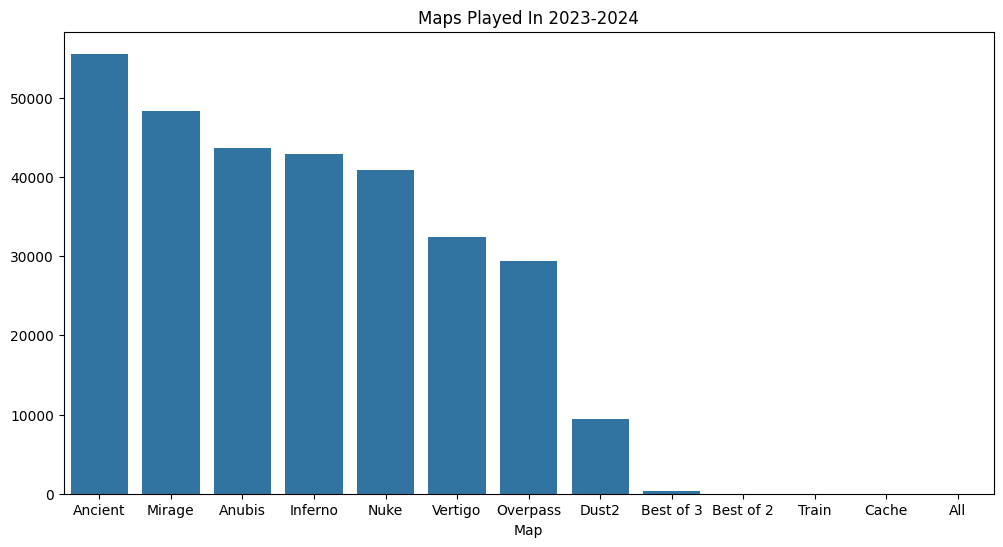

In [16]:
# Visual of the data
plt.figure(figsize=(12, 6))
sns.barplot(x=cs_data["Map"].value_counts().keys(), y=cs_data["Map"].value_counts().values)
plt.title("Maps Played In 2023-2024")
plt.show()

In [17]:
# Store the stats only as a dataframe
cs_stats = cs_data.iloc[:, :].query("(Map!='Best of 3') and (Map!='Best of 2') and (Map!= 'All') and (Map!='Train') and (Map!='Cache') and (Map!='Overpass')").reset_index(drop=True)
cs_stats.head()

,Event,Date,Map,Map Number,Team,Opponent Team,Name,Kills,Headshots,Assists,...,Teammate 4,Opponent 1,Opponent 2,Opponent 3,Opponent 4,Opponent 5,Teammate 5,Opponent 6,Opponent 7,Teammate 6
0,ESEA Advanced Season 50 North America,2024-09-21 21:30:00,Mirage,1,Akimbo,undefined,kralz,30,10,13,...,kmrn,chop,motm,stamina,CLASIA,BeaKie,NaN,NaN,NaN,NaN
1,ESEA Advanced Season 50 North America,2024-09-21 21:30:00,Mirage,1,Akimbo,undefined,N2o,35,9,7,...,kmrn,chop,motm,stamina,CLASIA,BeaKie,NaN,NaN,NaN,NaN
2,ESEA Advanced Season 50 North America,2024-09-21 21:30:00,Mirage,1,Akimbo,undefined,laxiee,27,15,14,...,kmrn,chop,motm,stamina,CLASIA,BeaKie,NaN,NaN,NaN,NaN
3,ESEA Advanced Season 50 North America,2024-09-21 21:30:00,Mirage,1,Akimbo,undefined,obi,25,12,12,...,kmrn,chop,motm,stamina,CLASIA,BeaKie,NaN,NaN,NaN,NaN
4,ESEA Advanced Season 50 North America,2024-09-21 21:30:00,Mirage,1,Akimbo,undefined,kmrn,24,14,6,...,obi,chop,motm,stamina,CLASIA,BeaKie,NaN,NaN,NaN,NaN


In [18]:
# Map values after querying
cs_stats["Map"].value_counts()

Map
Ancient    55562
Mirage     48386
Anubis     43639
Inferno    42938
Nuke       40834
Vertigo    32411
Dust2       9460
Name: count, dtype: int64

In [19]:
# Get info on the data after query filtering
cs_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273230 entries, 0 to 273229
Data columns (total 31 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Event           273230 non-null  object        
 1   Date            273230 non-null  datetime64[ns]
 2   Map             273230 non-null  object        
 3   Map Number      273230 non-null  object        
 4   Team            273230 non-null  object        
 5   Opponent Team   273230 non-null  object        
 6   Name            273230 non-null  object        
 7   Kills           273230 non-null  int64         
 8   Headshots       273230 non-null  int64         
 9   Assists         273230 non-null  int64         
 10  Deaths          273230 non-null  int64         
 11  Kast            273230 non-null  float64       
 12  K-D Diff        273230 non-null  int64         
 13  ADR             273230 non-null  float64       
 14  FK Diff         273230 non-null  int

In [20]:
# Drop the missing ADR values
cs_stats = cs_stats.dropna(axis=1).reset_index(drop=True)

In [21]:
# Missing values
cs_stats.isna().sum()

Event             0
Date              0
Map               0
Map Number        0
Team              0
Opponent Team     0
Name              0
Kills             0
Headshots         0
Assists           0
Deaths            0
Kast              0
K-D Diff          0
ADR               0
FK Diff           0
Rating            0
Team Score        0
Opponent Score    0
Teammate 1        0
Teammate 2        0
Teammate 3        0
Teammate 4        0
Opponent 1        0
Opponent 2        0
Opponent 3        0
Opponent 4        0
Opponent 5        0
dtype: int64

In [22]:
# Describe the data
cs_stats.drop("Date", axis=1).describe().round(3)

,Kills,Headshots,Assists,Deaths,Kast,K-D Diff,ADR,FK Diff,Rating,Team Score,Opponent Score
count,273230.000,273230.000,273230.000,273230.000,273230.000,273230.000,273230.000,273230.000,273230.000,273230.000,273230.000
mean,15.773,7.729,4.689,15.879,70.783,-0.106,73.198,-0.004,1.063,11.852,11.853
std,6.012,3.770,2.645,4.718,11.859,6.357,18.737,2.292,0.329,4.254,4.254
min,0.000,0.000,0.000,0.000,7.100,-29.000,0.400,-14.000,0.040,0.000,0.000
25%,12.000,5.000,3.000,13.000,63.300,-5.000,60.300,-1.000,0.840,9.000,9.000
50%,15.000,7.000,4.000,16.000,71.400,0.000,72.200,0.000,1.040,13.000,13.000
75%,19.000,10.000,6.000,19.000,78.900,4.000,84.900,1.000,1.260,16.000,16.000
max,63.000,38.000,28.000,58.000,100.000,29.000,193.500,13.000,3.150,37.000,37.000


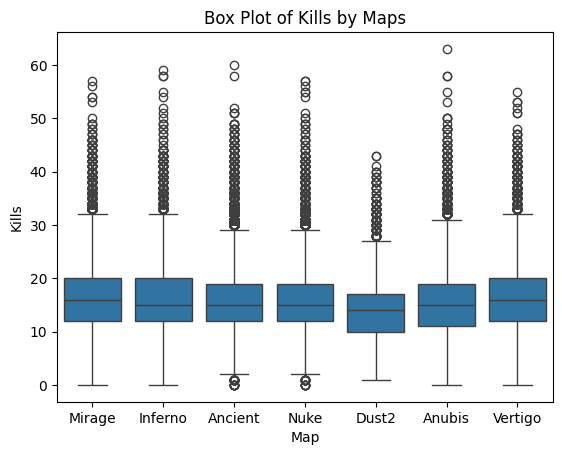

In [23]:
# Distribution of kills by maps
sns.boxplot(data=cs_stats, x="Map", y="Kills")
plt.title("Box Plot of Kills by Maps")
plt.show()

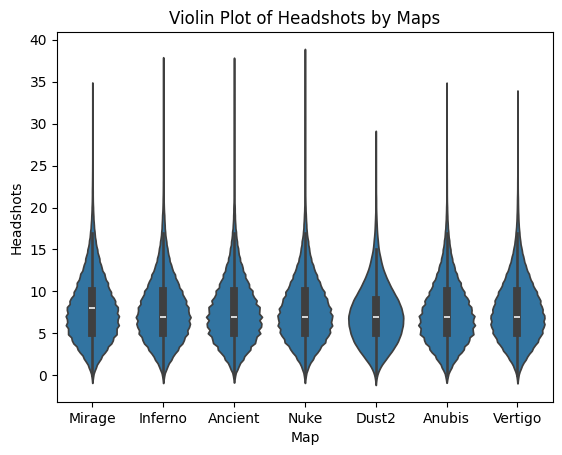

In [24]:
# Distribution of headshots by maps
sns.violinplot(data=cs_stats, x="Map", y="Headshots")
plt.title("Violin Plot of Headshots by Maps")
plt.show()

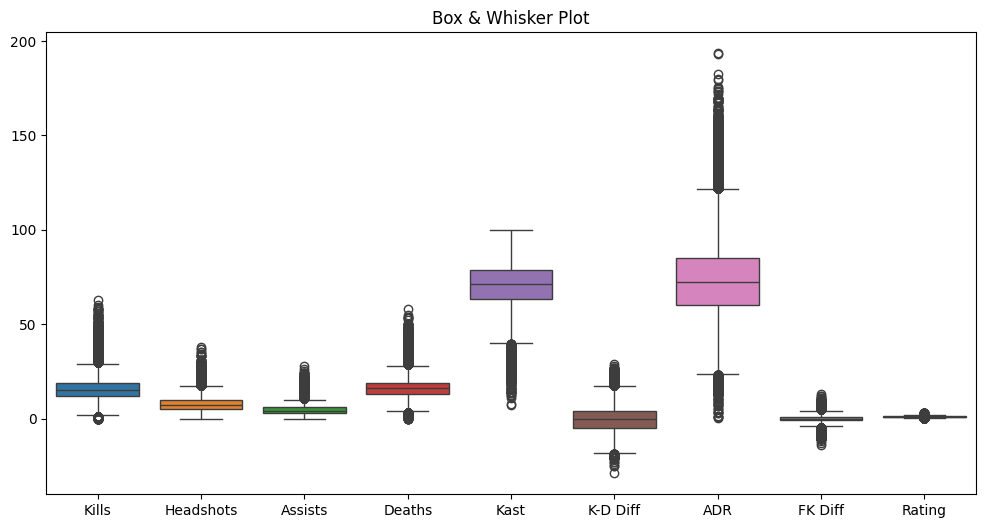

In [25]:
# Box & Whisker Plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=cs_stats.drop(columns=["Team Score", "Opponent Score"]))
plt.title("Box & Whisker Plot")
plt.show()

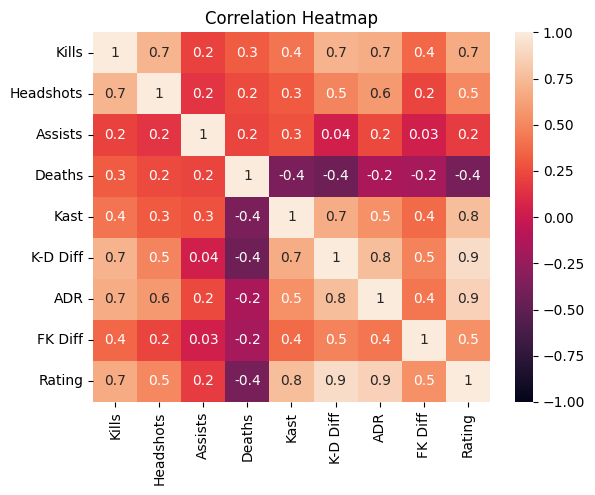

In [26]:
# Correlation matrix
corr_matrix = cs_stats.drop(columns=["Team Score", "Opponent Score"]).corr(numeric_only=True)

# Plot Heatmap
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True, fmt=".1g")
plt.title("Correlation Heatmap")
plt.show()

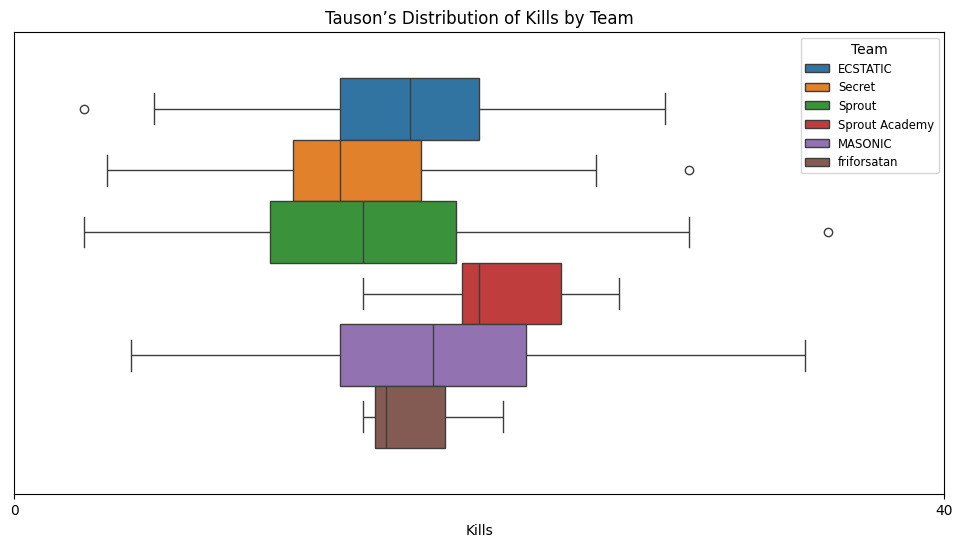

In [27]:
# Data for the player Tauson
tauson_data = cs_data[cs_data["Name"]=="Tauson"].drop(columns=["Team Score", "Opponent Score"])

# Plot
plt.figure(figsize=(12, 6))
plt.title("Tauson’s Distribution of Kills by Team")

# Box Plot
sns.boxplot(data=tauson_data, x="Kills", hue="Team")

# Adjust the legend
plt.legend(title="Team", loc="upper right", fontsize='small', title_fontsize='medium')

# Adjust ticks
plt.yticks([])
plt.xticks(ticks=(0, 40))

# Display the plot
plt.show()

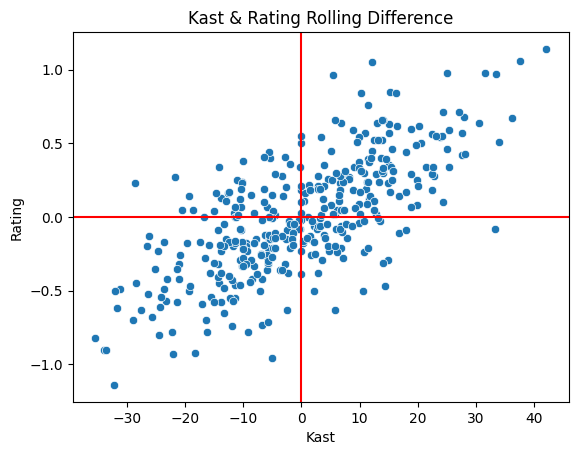

In [28]:
# Plot the relationship between Kast and Rating
sns.scatterplot(data=tauson_data[["Kast", "Rating"]].diff(), x="Kast", y="Rating")
plt.axhline(0, c="r")
plt.axvline(0, c="r")
plt.title("Kast & Rating Rolling Difference")
plt.show()

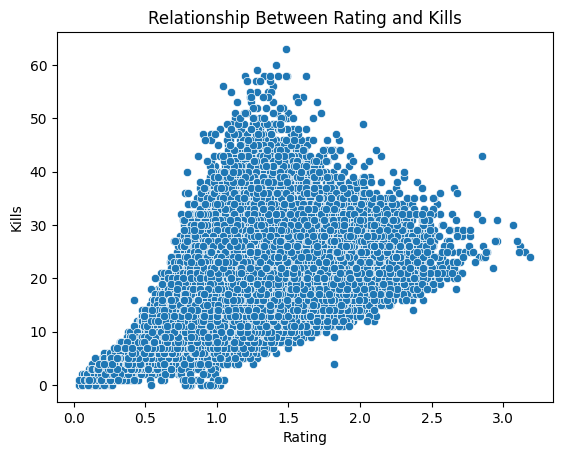

In [29]:
sns.scatterplot(data=cs_data, x="Rating", y="Kills")
plt.title("Relationship Between Rating and Kills")
plt.show()

## Data Preprocessing

- Calculate
    - **K/D ratio**
    - **Date** (Month & Year)

- Drop Columns
    - **Event**
    - **Team & Opponent Score**

- Encode
    - **Group Players**
    - **Group Teams**

In [30]:
# Filter to players that played at least 100 games with a team
cs_stats_f = cs_stats.groupby(["Name", "Team"]).filter(lambda group: len(group)>=100)
cs_stats_f.reset_index(drop=True, inplace=True)

In [31]:
# Calculate the K/D Ratio (replace 0's with 1)
cs_stats_f.insert(12, "K/D Ratio", cs_stats_f["Kills"]/(cs_stats_f["Deaths"].replace(0, 1)))
cs_stats_f.head()

,Event,Date,Map,Map Number,Team,Opponent Team,Name,Kills,Headshots,Assists,...,Opponent Score,Teammate 1,Teammate 2,Teammate 3,Teammate 4,Opponent 1,Opponent 2,Opponent 3,Opponent 4,Opponent 5
0,PrizePicks NA Revival Series 3,2024-09-21 20:10:00,Anubis,1,timbermen,BOSS,snav,13,7,7,...,16,shane,intra,dea,dare,freshie,Fruitcupx,SLIGHT,d4rty,Cryptic
1,PrizePicks NA Revival Series 3,2024-09-21 20:10:00,Anubis,1,timbermen,BOSS,dare,11,3,10,...,16,shane,intra,dea,snav,freshie,Fruitcupx,SLIGHT,d4rty,Cryptic
2,PrizePicks NA Revival Series 3,2024-09-21 20:10:00,Anubis,1,BOSS,timbermen,freshie,30,7,3,...,14,Fruitcupx,SLIGHT,d4rty,Cryptic,shane,intra,dea,snav,dare
3,PrizePicks NA Revival Series 3,2024-09-21 20:10:00,Anubis,1,BOSS,timbermen,d4rty,21,7,8,...,14,freshie,Fruitcupx,SLIGHT,Cryptic,shane,intra,dea,snav,dare
4,PrizePicks NA Revival Series 3,2024-09-21 20:10:00,Anubis,1,BOSS,timbermen,Cryptic,18,6,10,...,14,freshie,Fruitcupx,SLIGHT,d4rty,shane,intra,dea,snav,dare


In [32]:
# Get the month and year from the date column
cs_stats_f.insert(2, "Month", cs_stats_f["Date"].dt.month_name())
cs_stats_f.insert(3, "Year", cs_stats_f["Date"].dt.year)

In [33]:
# Replace values from the map numbers
cs_stats_f["Map Number"] = cs_stats_f["Map Number"].replace("Single Map", 0)

In [34]:
# Dropping columns
cs_stats_f.drop(["Event", "Date", "Team Score", "Opponent Score"], axis=1, inplace=True)
cs_stats_f.head()

,Month,Year,Map,Map Number,Team,Opponent Team,Name,Kills,Headshots,Assists,...,Rating,Teammate 1,Teammate 2,Teammate 3,Teammate 4,Opponent 1,Opponent 2,Opponent 3,Opponent 4,Opponent 5
0,September,2024,Anubis,1,timbermen,BOSS,snav,13,7,7,...,0.80,shane,intra,dea,dare,freshie,Fruitcupx,SLIGHT,d4rty,Cryptic
1,September,2024,Anubis,1,timbermen,BOSS,dare,11,3,10,...,0.62,shane,intra,dea,snav,freshie,Fruitcupx,SLIGHT,d4rty,Cryptic
2,September,2024,Anubis,1,BOSS,timbermen,freshie,30,7,3,...,1.45,Fruitcupx,SLIGHT,d4rty,Cryptic,shane,intra,dea,snav,dare
3,September,2024,Anubis,1,BOSS,timbermen,d4rty,21,7,8,...,1.13,freshie,Fruitcupx,SLIGHT,Cryptic,shane,intra,dea,snav,dare
4,September,2024,Anubis,1,BOSS,timbermen,Cryptic,18,6,10,...,1.11,freshie,Fruitcupx,SLIGHT,d4rty,shane,intra,dea,snav,dare


In [35]:
# Weighted moving average (weights)
weights = np.array([0.25, 0.20, 0.15, 0.125, 0.115, 0.10, 0.05, 0.01])

# Window size
n = 8

# Columns to apply weighted moving averages
weight_cols = ["Kills", "Headshots", "Assists", "Deaths", "Kast", "K/D Ratio", "K-D Diff", "ADR", "FK Diff", "Rating"]

# Group by an individual and the map they played on
wma_g = cs_stats_f.groupby(["Name", "Map"])[weight_cols].rolling(n, closed="left").apply(lambda group: np.dot(weights[::-1], group), raw=True)

In [36]:
# Reset the index and make sure it aligns with the dataframe
wma_g = wma_g.add_prefix("WMA ").reset_index().set_index("level_2").sort_index()

In [37]:
# Drop null values
wma_g.dropna(inplace=True)

# Merge the old dataframe with the WMA's
cs_stats_wma = pd.merge(
    left=cs_stats_f,
    right=wma_g.drop(columns=["Name", "Map"]),
    left_index=True,
    right_index=True
)

# Reset the index for the merged data
cs_stats_wma.reset_index(drop=True, inplace=True)

cs_stats_wma.head()

,Month,Year,Map,Map Number,Team,Opponent Team,Name,Kills,Headshots,Assists,...,WMA Kills,WMA Headshots,WMA Assists,WMA Deaths,WMA Kast,WMA K/D Ratio,WMA K-D Diff,WMA ADR,WMA FK Diff,WMA Rating
0,September,2024,Anubis,1,CYBERSHOKE,CPH Wolves,lov1kus,17,10,4,...,12.335,4.745,4.740,12.940,67.9620,1.035473,-0.605,71.9540,-1.305,1.01975
1,September,2024,Anubis,1,CYBERSHOKE,CPH Wolves,FenomeN,12,3,1,...,15.030,5.170,3.180,12.735,76.4065,1.357438,2.295,78.7660,0.730,1.18975
2,September,2024,Anubis,1,CYBERSHOKE,CPH Wolves,sstiNiX,15,8,5,...,19.510,11.005,2.940,12.770,71.8015,1.642299,6.740,102.0375,0.930,1.44520
3,September,2024,Anubis,1,CYBERSHOKE,CPH Wolves,levantino,12,9,6,...,14.430,8.470,5.870,14.005,72.1840,1.144623,0.425,82.6930,-0.285,1.14805
4,September,2024,Ancient,2,CPH Wolves,DMS,szejn,13,6,3,...,19.280,10.145,8.745,17.000,72.7470,1.202604,2.280,89.4365,1.510,1.26385


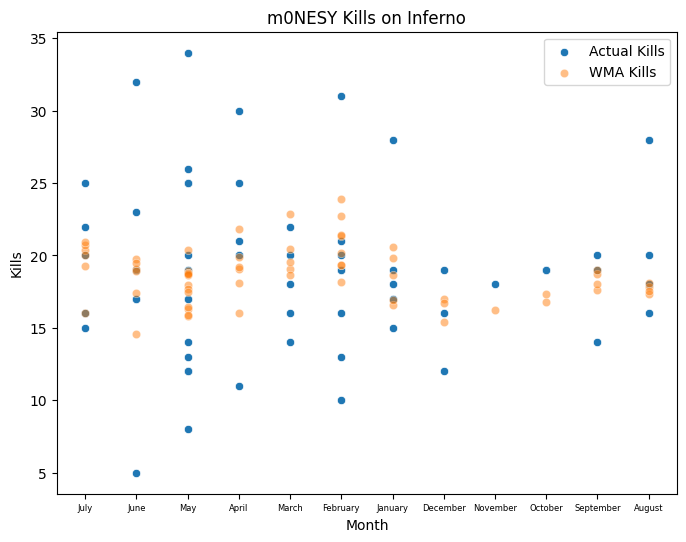

In [38]:
# Let's try to see how well the WMA line fits using m0NESY
m0NESY_inferno = cs_stats_wma[(cs_stats_wma["Name"]=="m0NESY") & (cs_stats_wma["Map"]=="Inferno")]

plt.figure(figsize=(8, 6))
plt.title("m0NESY Kills on Inferno")
# Actual kills
sns.scatterplot(data=m0NESY_inferno, x="Month", y="Kills", label="Actual Kills")

# WMA kills
sns.scatterplot(data=m0NESY_inferno, x="Month", y="WMA Kills", label="WMA Kills", alpha=0.5)

# Change tick size and add legend
plt.xticks(fontsize=6)
plt.legend()
plt.show()

## Encoding

In [39]:
# Need to convert these columns to numerical values for the ML model
cs_stats_wma.select_dtypes("object")

,Month,Map,Map Number,Team,Opponent Team,Name,Teammate 1,Teammate 2,Teammate 3,Teammate 4,Opponent 1,Opponent 2,Opponent 3,Opponent 4,Opponent 5
0,September,Anubis,1,CYBERSHOKE,CPH Wolves,lov1kus,notineki,FenomeN,sstiNiX,levantino,Fessor,szejn,eraa,sausol,Tapewaare
1,September,Anubis,1,CYBERSHOKE,CPH Wolves,FenomeN,lov1kus,notineki,sstiNiX,levantino,Fessor,szejn,eraa,sausol,Tapewaare
2,September,Anubis,1,CYBERSHOKE,CPH Wolves,sstiNiX,lov1kus,notineki,FenomeN,levantino,Fessor,szejn,eraa,sausol,Tapewaare
3,September,Anubis,1,CYBERSHOKE,CPH Wolves,levantino,lov1kus,notineki,FenomeN,sstiNiX,Fessor,szejn,eraa,sausol,Tapewaare
4,September,Ancient,2,CPH Wolves,DMS,szejn,sausol,eraa,Tapewaare,Fessor,AW,kAlash,sm3t,molodoy,sFade8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122400,January,Ancient,2,iNation,Monte,choiv7,VLDN,Dragon,Kind0,DEPRESHN,rallen,Woro2k,BOROS,kRaSnaL,DemQQ
122401,January,Ancient,2,iNation,Monte,Kind0,VLDN,Dragon,choiv7,DEPRESHN,rallen,Woro2k,BOROS,kRaSnaL,DemQQ
122402,January,Anubis,1,NAVI Junior,Lazer Cats,dem0n,UNBR0KEN,rendY,froz1k,yab0ku-,munch,Burmylov,t0kk,m1she4ka,Hkta
122403,January,Mirage,2,NAVI Junior,Lazer Cats,dem0n,UNBR0KEN,rendY,froz1k,yab0ku-,Burmylov,m1she4ka,munch,Hkta,t0kk


In [40]:
# Encode the month column
months_encoded = pd.get_dummies(cs_stats_wma["Month"], dtype="int")

# Encode the year column
years_encoded = pd.get_dummies(cs_stats_wma["Year"], dtype="int")

In [41]:
# Encode the map column
maps_encoded = pd.get_dummies(cs_stats_wma["Map"], dtype="int")

In [42]:
# Encode the map number column
map_nums_encoded = pd.get_dummies(cs_stats_wma["Map Number"], dtype="int")

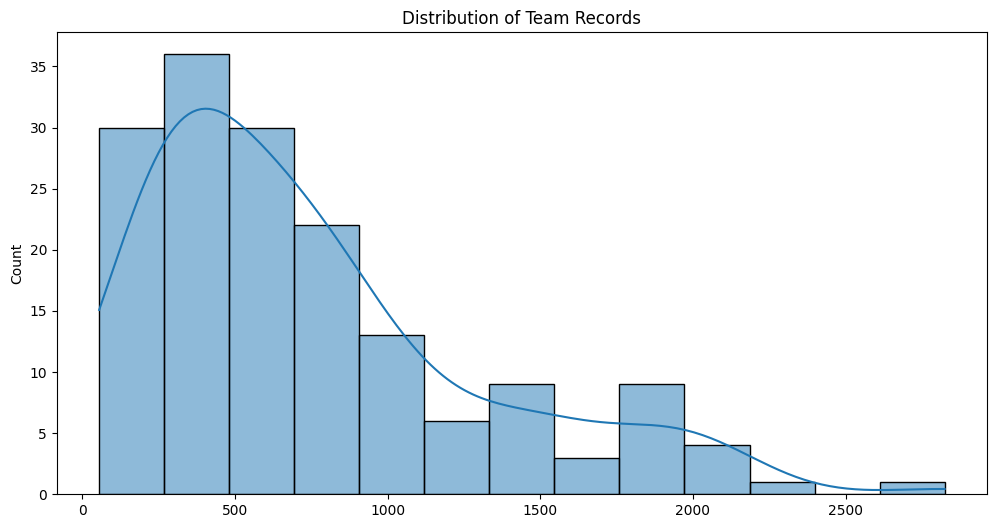

In [43]:
# Count the length of records for a team
record_team_counts = cs_stats_wma.groupby("Team").apply(lambda row: len(row)).sort_values()

# Plot it as a distribution
plt.figure(figsize=(12, 6))
plt.title("Distribution of Team Records")
sns.histplot(record_team_counts, kde=True)
plt.show()

In [44]:
# Initalize the encoder and add a smoother
tar_enc_team = ce.MEstimateEncoder(cols=["Team", "Opponent Team"], m=50)

# Encode only the names of the players
X = cs_stats_wma[["Team", "Opponent Team"]]
y = cs_stats_wma["Kills"]

# Fit and transform the model
tar_enc_team.fit(X, y)

MEstimateEncoder(cols=['Team', 'Opponent Team'], m=50)

In [45]:
# Transform team columns
tar_trans_teams = tar_enc_team.transform(cs_stats_wma[["Team", "Opponent Team"]])

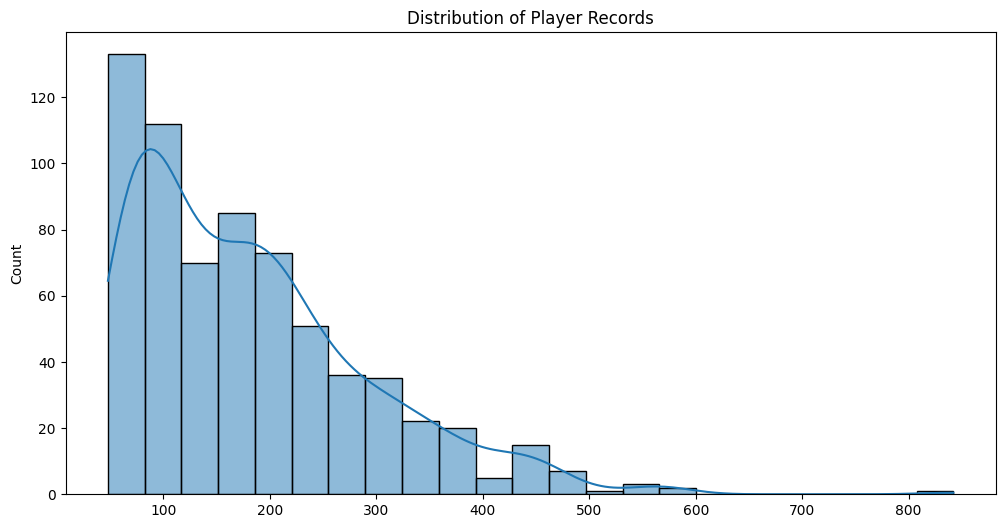

In [46]:
# Count the length of records for a player
record_player_counts = cs_stats_wma.groupby("Name").apply(lambda row: len(row)).sort_values()

# Plot it as a distribution
plt.figure(figsize=(12, 6))
plt.title("Distribution of Player Records")
sns.histplot(record_player_counts, kde=True)
plt.show()

In [47]:
player_cols = list(cs_stats_wma.select_dtypes("object").columns)[5:]

In [48]:
# Initalize the encoder and add a smoother
tar_enc_player = ce.MEstimateEncoder(cols=player_cols, m=100)

# Encode only the names of the players
X = cs_stats_wma[player_cols]
y = cs_stats_wma["Kills"]

# Fit and transform the model
tar_enc_player.fit(X, y)

MEstimateEncoder(cols=['Name', 'Teammate 1', 'Teammate 2', 'Teammate 3',
                       'Teammate 4', 'Opponent 1', 'Opponent 2', 'Opponent 3',
                       'Opponent 4', 'Opponent 5'],
                 m=100)

In [49]:
# Transform player columns
tar_trans_players = tar_enc_player.transform(cs_stats_wma[player_cols])

In [50]:
# Store the WMA's as a datframe
wma_clean = cs_stats_wma[
        [
        'Kills', 'Headshots',
        'WMA Kills', 'WMA Headshots', 'WMA Assists', 'WMA Deaths', 'WMA Kast',
        'WMA K-D Diff', 'WMA ADR', 'WMA FK Diff', 'WMA Rating'
        ]
    ]

In [51]:
# Build the ML model dataframe
ml_df = pd.concat(
    [
        months_encoded,
        # years_encoded,
        maps_encoded,
        tar_trans_teams,
        tar_trans_players,
        wma_clean
    ],
    axis=1
)

# Make sure the columns are strings
ml_df.columns = ml_df.columns.astype("str")
ml_df.head()

,April,August,December,February,January,July,June,March,May,November,...,Headshots,WMA Kills,WMA Headshots,WMA Assists,WMA Deaths,WMA Kast,WMA K-D Diff,WMA ADR,WMA FK Diff,WMA Rating
0,0,0,0,0,0,0,0,0,0,0,...,10,12.335,4.745,4.740,12.940,67.9620,-0.605,71.9540,-1.305,1.01975
1,0,0,0,0,0,0,0,0,0,0,...,3,15.030,5.170,3.180,12.735,76.4065,2.295,78.7660,0.730,1.18975
2,0,0,0,0,0,0,0,0,0,0,...,8,19.510,11.005,2.940,12.770,71.8015,6.740,102.0375,0.930,1.44520
3,0,0,0,0,0,0,0,0,0,0,...,9,14.430,8.470,5.870,14.005,72.1840,0.425,82.6930,-0.285,1.14805
4,0,0,0,0,0,0,0,0,0,0,...,6,19.280,10.145,8.745,17.000,72.7470,2.280,89.4365,1.510,1.26385


## Machine Learning

In [52]:
# Split independent and dependent variables
X = ml_df.drop(columns=["Kills", "Headshots"])
y = ml_df[["Kills", "Headshots"]]

# Split into 80% training and 20% testing
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.80, shuffle=True, random_state=42)

In [53]:
# Initalize the regression models
lr = LinearRegression()
lasso = Lasso()
dtr = DecisionTreeRegressor()
xgr = XGBRegressor()

In [54]:
def model_scores(model, x_train, y_train, x_test, y_test, boost=False):
    # Fit the model
    if boost==False:
        model.fit(x_train, y_train)
    # Make predictions on testing set
    y_pred = model.predict(x_test)
    # Scores
    r2 = r2_score(y_test, y_pred, multioutput="raw_values")
    mae = mean_absolute_error(y_test, y_pred, multioutput="raw_values")
    rmse = root_mean_squared_error(y_test, y_pred, multioutput="raw_values")
    print(f"Mean Absolute Error (Kills): {mae[0]}")
    print(f"Mean Absolute Error (Headshots): {mae[1]}")
    print(f"Root Mean Squared Error (Kills): {rmse[0]}")
    print(f"Root Mean Squared Error (Headshots): {rmse[1]}")
    return model, r2, mae, rmse, y_pred

In [55]:
# Plot the residuals
def plot_residuals(preds, actual, model_type):
    # Make a copy of the y_test
    resi_y_test = actual.copy()

    # Store the residuals
    residuals = actual - preds

    # Put it into the dataframe
    resi_y_test[["Kills Predicted", "Headshots Predicted"]] = preds
    resi_y_test[["Kills Residuals", "Headshots Residuals"]] = residuals

    # Plot both kills and headshots
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    # Set the title for the entire figure
    fig.suptitle(model_type, fontsize=14)
    fig.set_tight_layout(tight=True)

    # Plotting the kills
    ax[0].scatter(x=resi_y_test["Kills Predicted"], y=resi_y_test["Kills Residuals"], alpha=0.2)
    ax[0].set_title("Residual Plot For Kills")
    ax[0].set_xlabel("$\hat{{y}}$")
    ax[0].axhline(0, c="r")

    # Plotting the headshots
    ax[1].scatter(x=resi_y_test["Headshots Predicted"], y=resi_y_test["Headshots Residuals"], alpha=0.2)
    ax[1].set_title("Residual Plot For Headshots")
    ax[1].set_xlabel("$\hat{{y}}$")
    ax[1].axhline(0, c="r")

Mean Absolute Error (Kills): 4.281410539838293
Mean Absolute Error (Headshots): 2.701431773670222
Root Mean Squared Error (Kills): 5.497699265460987
Root Mean Squared Error (Headshots): 3.4517916802413713


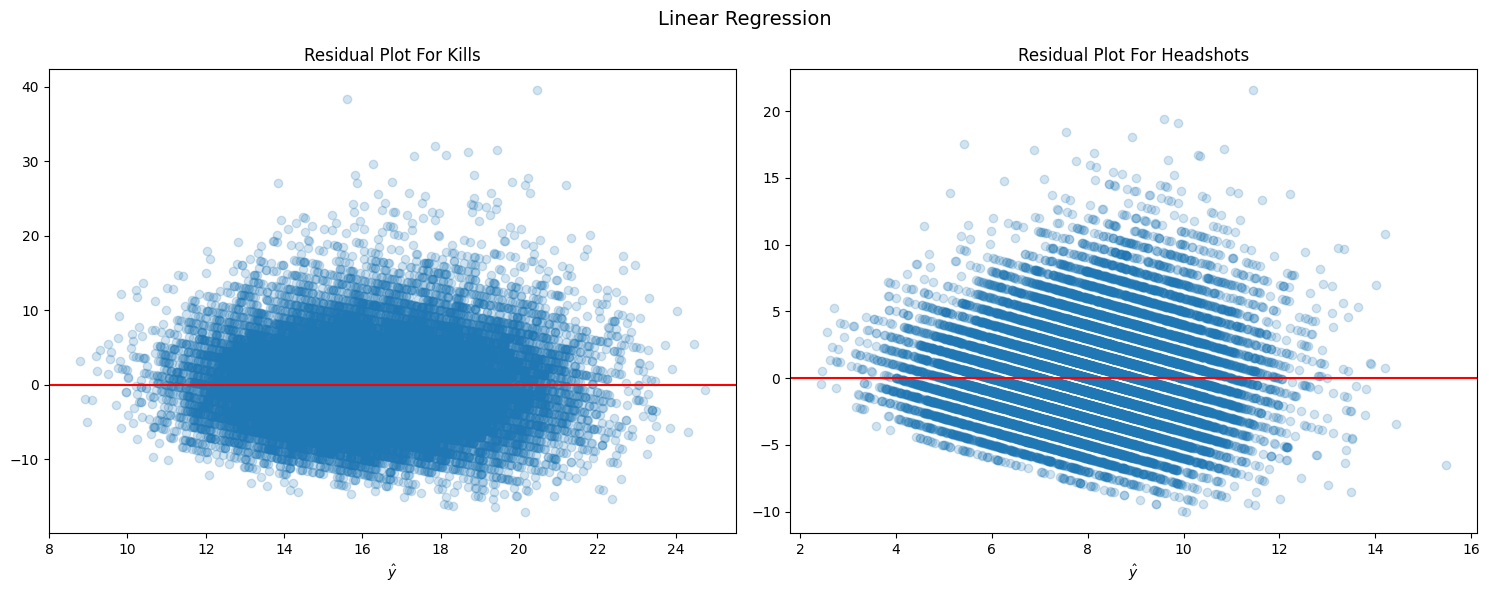

In [56]:
lr, r2, mae, rmse, y_pred_lr = model_scores(lr, x_train, y_train, x_test, y_test)
plot_residuals(y_pred_lr, y_test, "Linear Regression")

Mean Absolute Error (Kills): 4.485666474384171
Mean Absolute Error (Headshots): 2.803738773814943
Root Mean Squared Error (Kills): 5.768918834547908
Root Mean Squared Error (Headshots): 3.5761543421594304


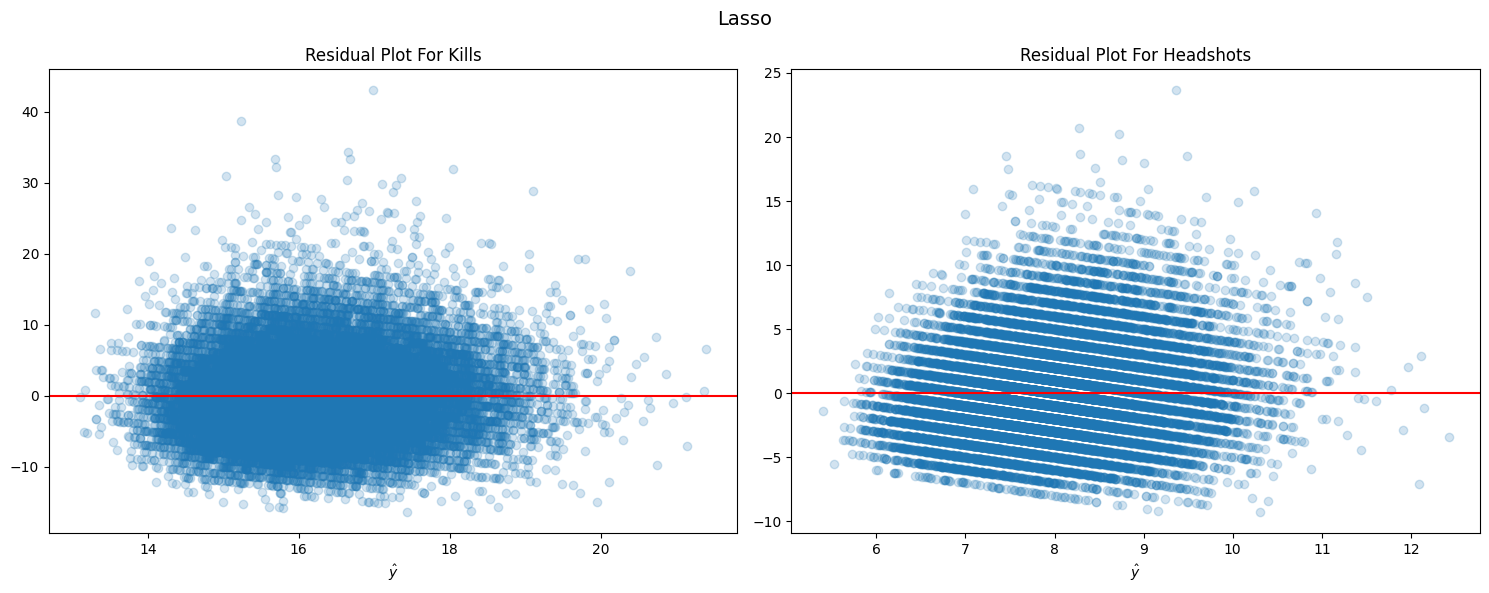

In [57]:
lasso, r2, mae, rmse, y_pred_lasso = model_scores(lasso, x_train, y_train, x_test, y_test)
plot_residuals(y_pred_lasso, y_test, "Lasso")

Mean Absolute Error (Kills): 6.18263142845472
Mean Absolute Error (Headshots): 3.879947714554144
Root Mean Squared Error (Kills): 7.951969188709622
Root Mean Squared Error (Headshots): 4.991365445881282


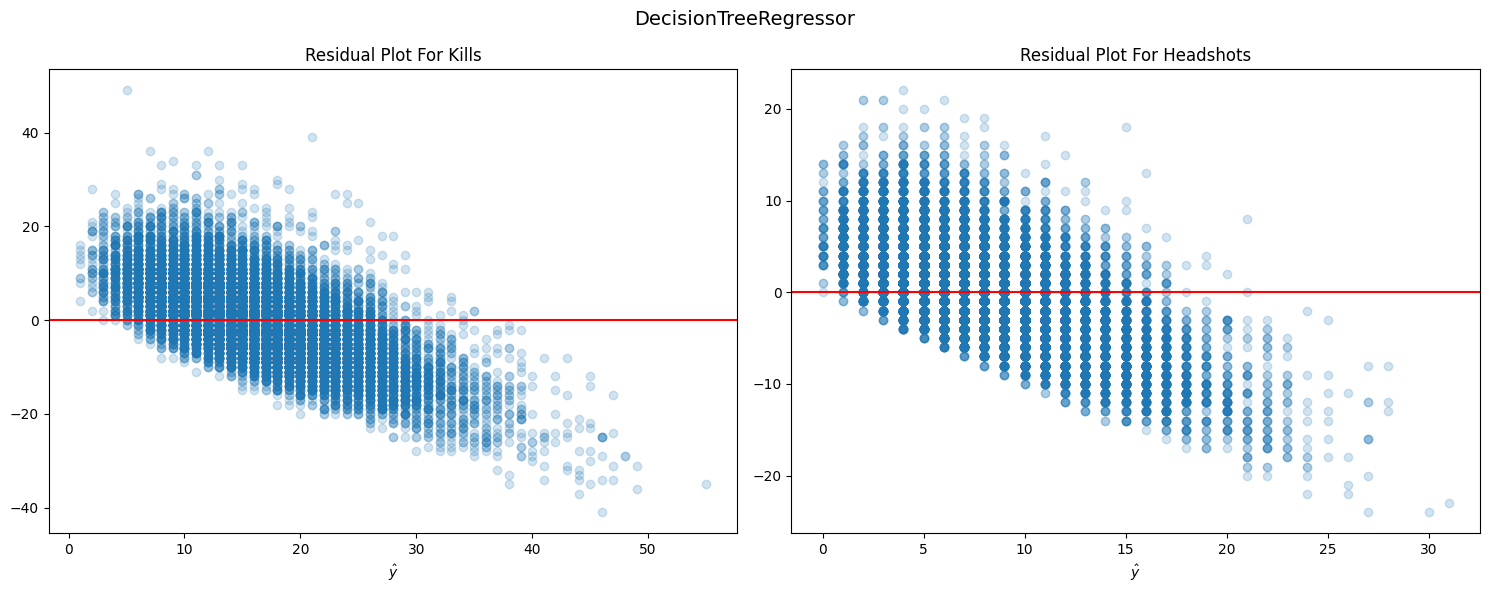

In [58]:
dtr, r2, mae, rmse, y_pred_dtr = model_scores(dtr, x_train, y_train, x_test, y_test)
plot_residuals(y_pred_dtr, y_test, "DecisionTreeRegressor")

Mean Absolute Error (Kills): 4.231684030473079
Mean Absolute Error (Headshots): 2.693312222333054
Root Mean Squared Error (Kills): 5.419497756565012
Root Mean Squared Error (Headshots): 3.4481312819471746


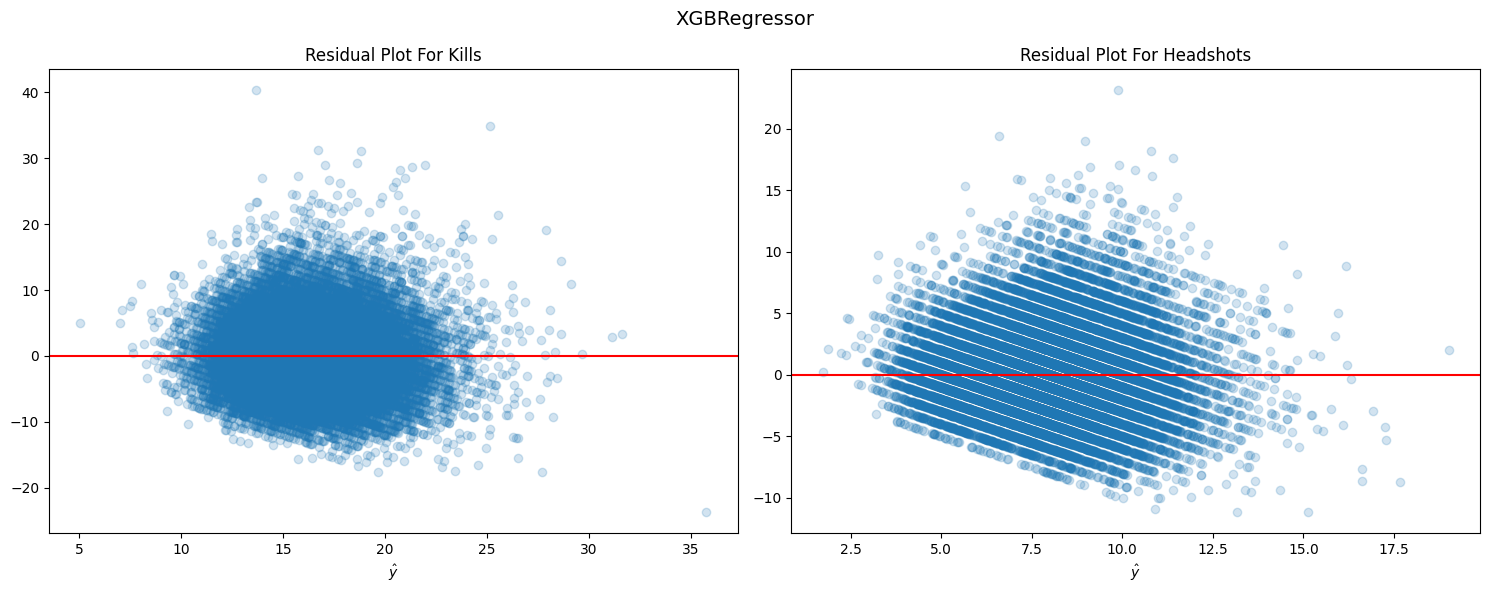

In [59]:
xgr, r2, mae, rmse, y_pred_xgr = model_scores(xgr, x_train, y_train, x_test, y_test)
plot_residuals(y_pred_xgr, y_test, "XGBRegressor")

In [60]:
# Import saved model
xgrb = joblib.load("xgrb.joblib")

Mean Absolute Error (Kills): 4.240369066762201
Mean Absolute Error (Headshots): 2.6803385248702702
Root Mean Squared Error (Kills): 5.482875151287173
Root Mean Squared Error (Headshots): 3.454554298920233


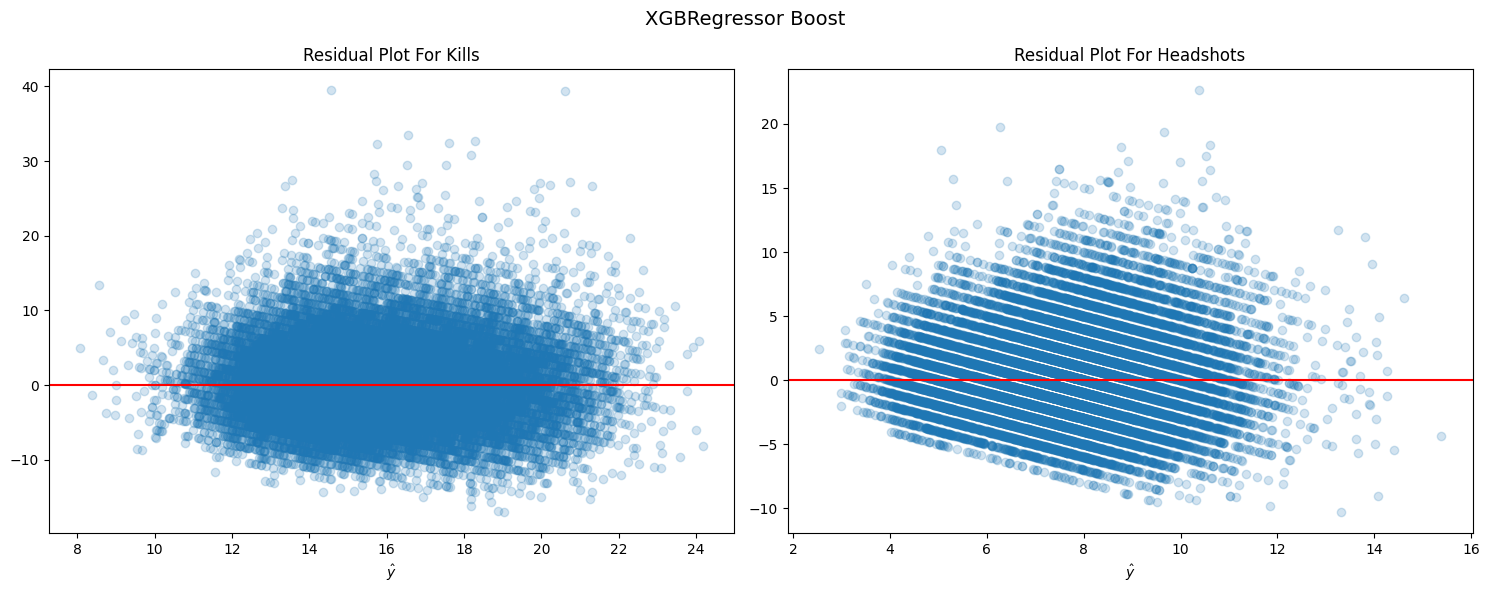

In [61]:
# Evaluate the boosted regression model
xgrb, r2, mae, rmse, y_pred_xgrb = model_scores(xgrb, x_train, y_train, x_test, y_test, True)
plot_residuals(y_pred_xgrb, y_test, "XGBRegressor Boost")

## Predictions

In [62]:
# Input the player name
player_name = input("Enter the name of the player to project: ")

# Store the data of players
player_data = project_player(player_name)

# Rename the columns for the model to work
player_data.rename(columns={"Kills": "WMA Kills",
                            "Headshots": "WMA Headshots",
                            "Assists": "WMA Assists",
                            "Deaths": "WMA Deaths",
                            "Kast": "WMA Kast",
                            "K-D Diff": "WMA K-D Diff",
                            "ADR": "WMA ADR",
                            "FK Diff": "WMA FK Diff",
                            "Rating": "WMA Rating",
                            }, inplace=True)

# Encode the teams
player_data[["Team", "Opponent Team"]] = tar_enc_team.transform(player_data[["Team", "Opponent Team"]])

# Encode the players
player_data[player_cols] = tar_enc_player.transform(player_data[player_cols])

# Store the order of maps
maps = [
        "Dust2", "Nuke",
        "Ancient", "Inferno",
        "Mirage", "Anubis", "Vertigo"
    ]

# Store the predictions
predictions = xgr.predict(player_data).round()

# Create a DataFrame by combining the two
prediction_df = pd.DataFrame(predictions, index=maps[:len(predictions)], columns=["Kills", "Headshots"])

# Print name
print(f"Projections For {player_name}")

# Display the projections
print(prediction_df)

100%|██████████| 7/7 [01:22<00:00, 11.77s/it]


Projections For zock
         Kills  Headshots
Dust2     19.0        8.0
Nuke      17.0        7.0
Ancient   17.0        8.0
Inferno   17.0        9.0
Mirage    16.0        8.0
Anubis    15.0        8.0
